In [ ]:
#Importing all the key libraries
import os
os.environ['WANDB_API_KEY'] = 'abc3e61cc8dfd07d2ba9a8661065c6de5303174d' #change it to your wandb API
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from PIL import Image
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import wandb
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torchvision.transforms import ToTensor

## Utility code

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    """ Custom Image dataset which overrides torch dataset class. Initialises
    the dataset and enables us to code the logic of retrieving images and labels from
    the directory structure we have
    """
    def __init__(self, dir, limit=None, indices=None, transform=None):
        self.data_dir = dir
        self.limit = int(1e10) if limit is None else limit
        self.images = []
        self.labels = []
        self.label_names = []
        i = 0
        for c in os.listdir(dir):
          ims = os.listdir(os.path.join(dir,c))[:self.limit]
          ims = [os.path.join(dir,c,im) for im in ims]
          self.images.extend(ims)
          self.labels.extend([i]*len(ims))
          self.label_names.append(c)
          i += 1

        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
        self.transform = transform

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = image.convert("RGB")
        label = self.labels[index]
        # Applying the transform
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def split_validation(label_array, valid_size = 0.1, seed = 42):
  """The functions splits the data into train and validation stratifiedly
  """
  train_idx, test_idx = [],[]
  for i,ci in enumerate(np.unique(label_array)):
      indices = np.where(label_array==ci)[0]
      train_len = int(indices.shape[0]*(1-valid_size))
      shuffled = np.random.RandomState(seed+i).permutation(indices)
      train_idx.extend(shuffled[:train_len])
      test_idx.extend(shuffled[train_len:])
  return train_idx,test_idx

In [ ]:
def set_seed(seed=42):
    """Sets random seeds for reproducibility.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.cuda.manual_seed_all(seed)

In [ ]:
class Trainer:
  """ Trainer agent which handles the training
  """
  def __init__(self):
    """ Initializing agent parameters
    """
    self.input_size = (224,224)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = None
    self.train_loader = None
    self.val_loader = None
    self.test_ds = None
    self.test_loader = None

  def create_model(self):
    """Fetches a pretrained model and takes care of freezing and unfreezing layers"
    """
    num_classes = 10
    model = models.resnet50(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False  # freeze everything
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
        )
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True  # train only the head

    model.to(self.device)
    self.optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    self.model = model

  def create_data(self, batch_size, data_aug=False, limit=None, train=False):
      """ Creates a dataset with augmentation transforms if required. The limit
      controls how much of the dataset that we want to choose
      """
      TRAIN_DATA_PATH = "/kaggle/input/inaturalist/inaturalist_12K/train"
      TEST_DATA_PATH = "/kaggle/input/inaturalist/inaturalist_12K/val"

      base_transform = transforms.Compose([
                transforms.Resize(self.input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
              ])
      if data_aug:
          aug_transform = transforms.Compose([
                transforms.Resize(self.input_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
              ])
      else:
          aug_transform = base_transform

      # we apply data augmentation only to the train dataset
      if train:
        full_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=None)
        train_idx, val_idx = split_validation(
            full_dataset.labels, valid_size=0.2, seed=42)
        train_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=aug_transform, indices=train_idx)
        val_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=base_transform, indices=val_idx)
        self.train_loader = DataLoader(
            dataset=train_dataset, batch_size=batch_size,
            shuffle=True, num_workers=2)
        self.val_loader = DataLoader(
            dataset=val_dataset, batch_size=batch_size,
            num_workers=2)
      else:
        self.test_ds = CustomImageDataset(
            TEST_DATA_PATH, limit=limit, transform=base_transform)
        self.test_loader = DataLoader(
          num_workers=2,dataset=self.test_ds, batch_size=batch_size)

  def worker_init_fn(self, worker_id):
      """ Set worker seed for reproducibility
      """
      np.random.seed(torch.initial_seed() % 2**32)

  def run_step(self, dataloader, is_train=False):
      """ Runs one step of optimization if needed and evaluates the model
      """
      correct = 0
      total = 0
      cum_loss = 0
      if is_train:
        self.model.train()
      else:
        self.model.eval()

      for batch_index, (data, targets) in enumerate(tqdm(dataloader)):
          data = data.to(self.device)
          targets = targets.to(self.device)

          with torch.set_grad_enabled(is_train):
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)
            cum_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (preds == targets).sum().item()
            if is_train:
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
      acc = correct/total
      return cum_loss, acc

  def run_train_pipeline(self, n_epochs, limit=None, use_wandb=False, config=None):
      """ Pipeline setup for the whole training process, includes data creation, model
      creation, integration with wandb and model evaluation
      """
      if use_wandb:
        run = wandb.run
      else:
        run = None

      set_seed(42)
      batch_size = config.batch_size
      data_aug = config.data_aug

      self.create_model()
      self.create_data(batch_size, data_aug=data_aug, limit=limit, train=True)

      for epoch in range(n_epochs):
        train_loss, train_acc = self.run_step(self.train_loader, is_train=True)
        val_loss, val_acc = self.run_step(self.val_loader)
        if run:
          wandb.log({
              'epoch':epoch,
              'train_loss':train_loss, 'train_acc':train_acc,
              'val_loss':val_loss, 'val_acc':val_acc
          })
        else:
          print({
              'epoch':epoch,
              'train_loss':train_loss, 'train_acc':train_acc,
              'val_loss':val_loss, 'val_acc':val_acc
          })



  def test(self):
      batch_size = 128
      self.create_data(batch_size)
      self.model.eval()
      test_loss,test_acc = self.run_step(self.test_loader)
      print(f"Loss on test set : {test_loss}")
      print(f"Accuracy on test set : {test_acc}")


## Model training and evaluation

In [ ]:
from types import SimpleNamespace
batch_size = 128
data_aug = True

config = SimpleNamespace(
   batch_size=batch_size,
   data_aug = data_aug
)

In [ ]:
n_epochs = 30
tr = Trainer()
tr.run_train_pipeline(n_epochs=n_epochs, limit=None, use_wandb=False, config=config)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 
100%|██████████| 16/16 [00:29<00:00,  1.87s/it]


{'epoch': 0, 'train_loss': 143.8648202419281, 'train_acc': 0.17189648706088262, 'val_loss': 36.02696657180786, 'val_acc': 0.31}


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


{'epoch': 1, 'train_loss': 139.27291679382324, 'train_acc': 0.39704963120390047, 'val_loss': 34.696574211120605, 'val_acc': 0.534}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 2, 'train_loss': 132.3580595254898, 'train_acc': 0.5603200400050006, 'val_loss': 32.43168902397156, 'val_acc': 0.6315}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 3, 'train_loss': 119.92912304401398, 'train_acc': 0.6412051506438304, 'val_loss': 28.08979856967926, 'val_acc': 0.678}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 4, 'train_loss': 99.31396543979645, 'train_acc': 0.682710338792349, 'val_loss': 21.875125288963318, 'val_acc': 0.7205}


100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


{'epoch': 5, 'train_loss': 76.72088623046875, 'train_acc': 0.717589698712339, 'val_loss': 16.804656445980072, 'val_acc': 0.747}


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


{'epoch': 6, 'train_loss': 61.50908952951431, 'train_acc': 0.7425928241030129, 'val_loss': 13.718452095985413, 'val_acc': 0.7635}


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


{'epoch': 7, 'train_loss': 52.65409046411514, 'train_acc': 0.760220027503438, 'val_loss': 12.194223880767822, 'val_acc': 0.775}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 8, 'train_loss': 47.38526552915573, 'train_acc': 0.7760970121265158, 'val_loss': 11.111341178417206, 'val_acc': 0.79}


100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


{'epoch': 9, 'train_loss': 43.657742232084274, 'train_acc': 0.7834729341167646, 'val_loss': 10.355717360973358, 'val_acc': 0.8}


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


{'epoch': 10, 'train_loss': 40.284764885902405, 'train_acc': 0.8049756219527441, 'val_loss': 9.866431891918182, 'val_acc': 0.803}


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


{'epoch': 11, 'train_loss': 38.20057600736618, 'train_acc': 0.8089761220152519, 'val_loss': 9.35214439034462, 'val_acc': 0.8125}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 12, 'train_loss': 35.77226799726486, 'train_acc': 0.8198524815601951, 'val_loss': 9.159435510635376, 'val_acc': 0.8105}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 13, 'train_loss': 34.45573028922081, 'train_acc': 0.8231028878609826, 'val_loss': 8.861071288585663, 'val_acc': 0.8195}


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


{'epoch': 14, 'train_loss': 32.79625868797302, 'train_acc': 0.8349793724215527, 'val_loss': 8.693642616271973, 'val_acc': 0.822}


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


{'epoch': 15, 'train_loss': 31.319720536470413, 'train_acc': 0.8424803100387549, 'val_loss': 8.549262791872025, 'val_acc': 0.829}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 16, 'train_loss': 29.853248476982117, 'train_acc': 0.8502312789098637, 'val_loss': 8.421207934617996, 'val_acc': 0.833}


100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


{'epoch': 17, 'train_loss': 28.68411147594452, 'train_acc': 0.8562320290036255, 'val_loss': 8.251497775316238, 'val_acc': 0.833}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 18, 'train_loss': 27.479311138391495, 'train_acc': 0.8611076384548069, 'val_loss': 8.186438530683517, 'val_acc': 0.8315}


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


{'epoch': 19, 'train_loss': 26.543534725904465, 'train_acc': 0.8586073259157395, 'val_loss': 8.155819684267044, 'val_acc': 0.8345}


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


{'epoch': 20, 'train_loss': 24.80103924870491, 'train_acc': 0.8713589198649832, 'val_loss': 8.005075931549072, 'val_acc': 0.8355}


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


{'epoch': 21, 'train_loss': 24.488807305693626, 'train_acc': 0.8722340292536567, 'val_loss': 7.963870644569397, 'val_acc': 0.835}


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


{'epoch': 22, 'train_loss': 23.553580433130264, 'train_acc': 0.8762345293161645, 'val_loss': 7.8448914885520935, 'val_acc': 0.841}


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


{'epoch': 23, 'train_loss': 22.69967895746231, 'train_acc': 0.8829853731716465, 'val_loss': 7.840274930000305, 'val_acc': 0.839}


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


{'epoch': 24, 'train_loss': 21.805647626519203, 'train_acc': 0.8888611076384548, 'val_loss': 7.893194526433945, 'val_acc': 0.839}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 25, 'train_loss': 20.61683289706707, 'train_acc': 0.8932366545818228, 'val_loss': 7.829648524522781, 'val_acc': 0.8365}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 26, 'train_loss': 19.863220795989037, 'train_acc': 0.8992374046755844, 'val_loss': 7.859689354896545, 'val_acc': 0.8425}


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


{'epoch': 27, 'train_loss': 19.81357392668724, 'train_acc': 0.897362170271284, 'val_loss': 7.786284267902374, 'val_acc': 0.8405}


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


{'epoch': 28, 'train_loss': 18.88368183374405, 'train_acc': 0.9046130766345793, 'val_loss': 7.806801348924637, 'val_acc': 0.844}


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

{'epoch': 29, 'train_loss': 18.143728151917458, 'train_acc': 0.9083635454431804, 'val_loss': 7.801267504692078, 'val_acc': 0.8455}


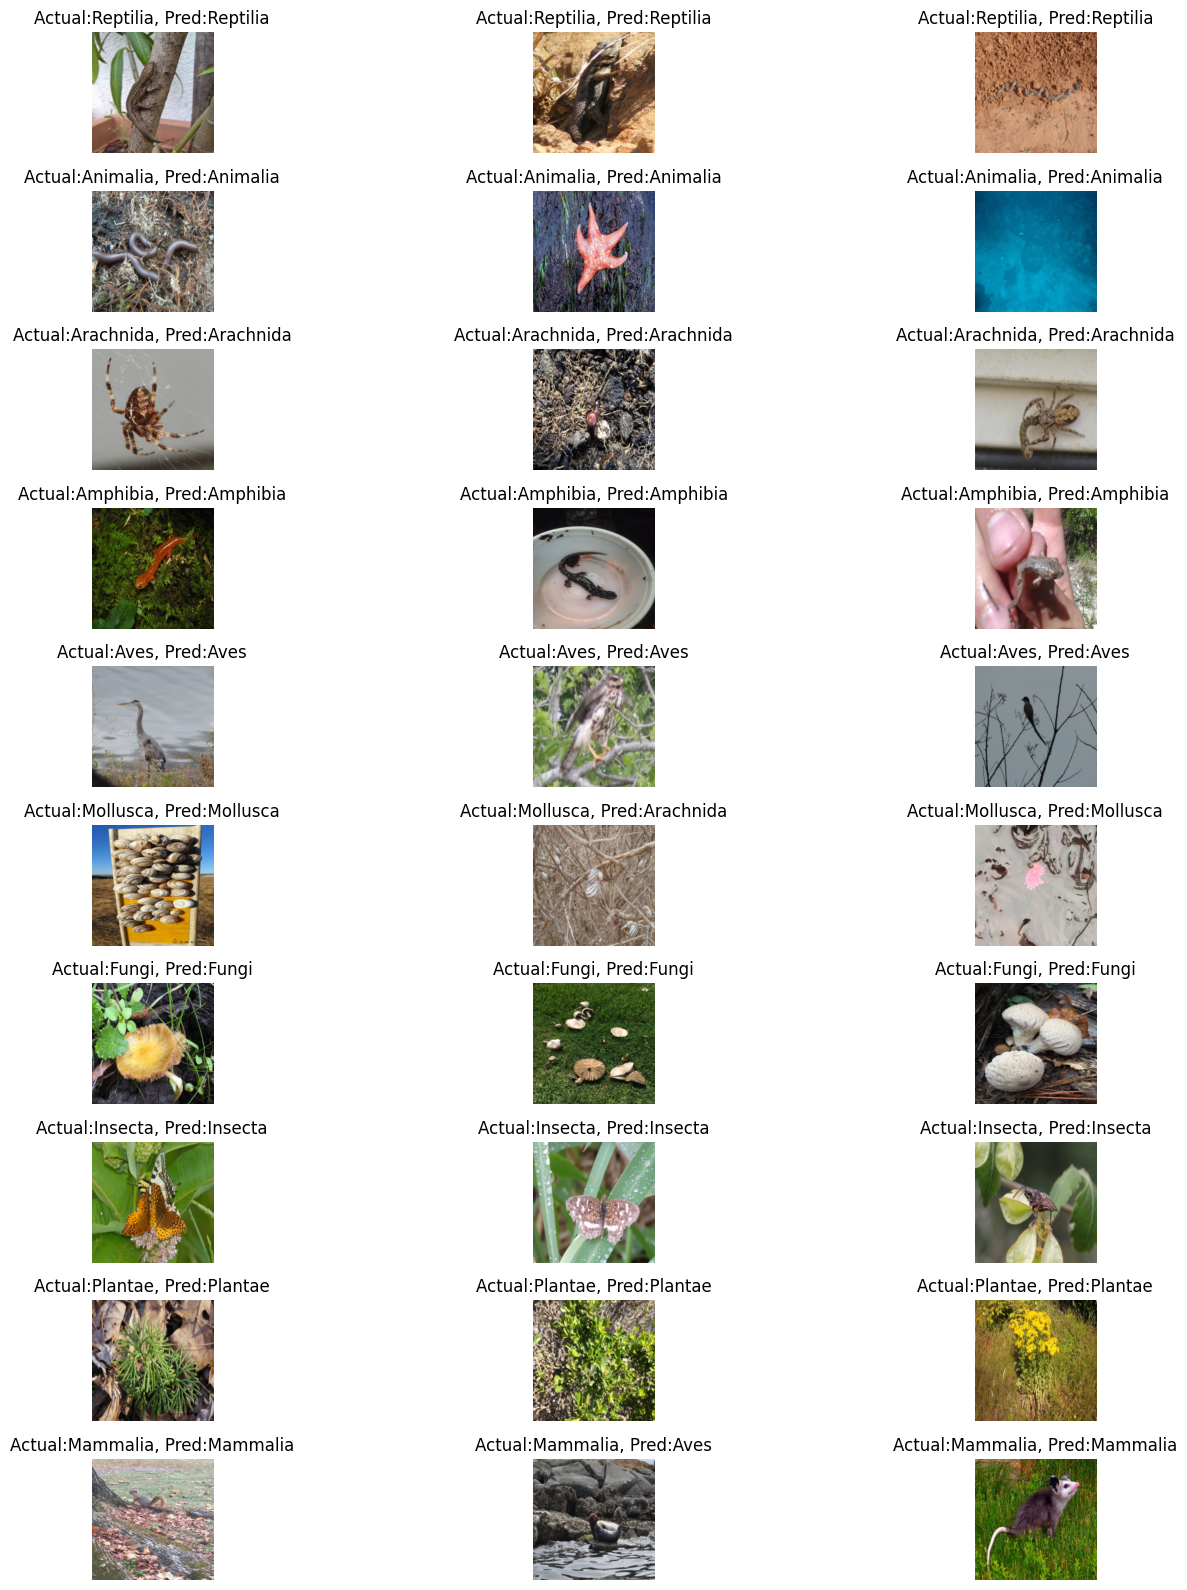

In [ ]:
visualize_predictions()